## fMRI-to-Image with Contrastive Learning and Diffusion Priors

Several projects have been proposed to either retrival or reconstruct images from brain (fMRI) stumuli. Those are based on the Natural Scene Dataset (NSD).
The most recent is MindEye: https://medarc-ai.github.io/mindeye/

Running the whole system is possible as the dataset is available freely on an AWS repo, but not through a colab. We limit ourself to run the DeepNSD tutorial.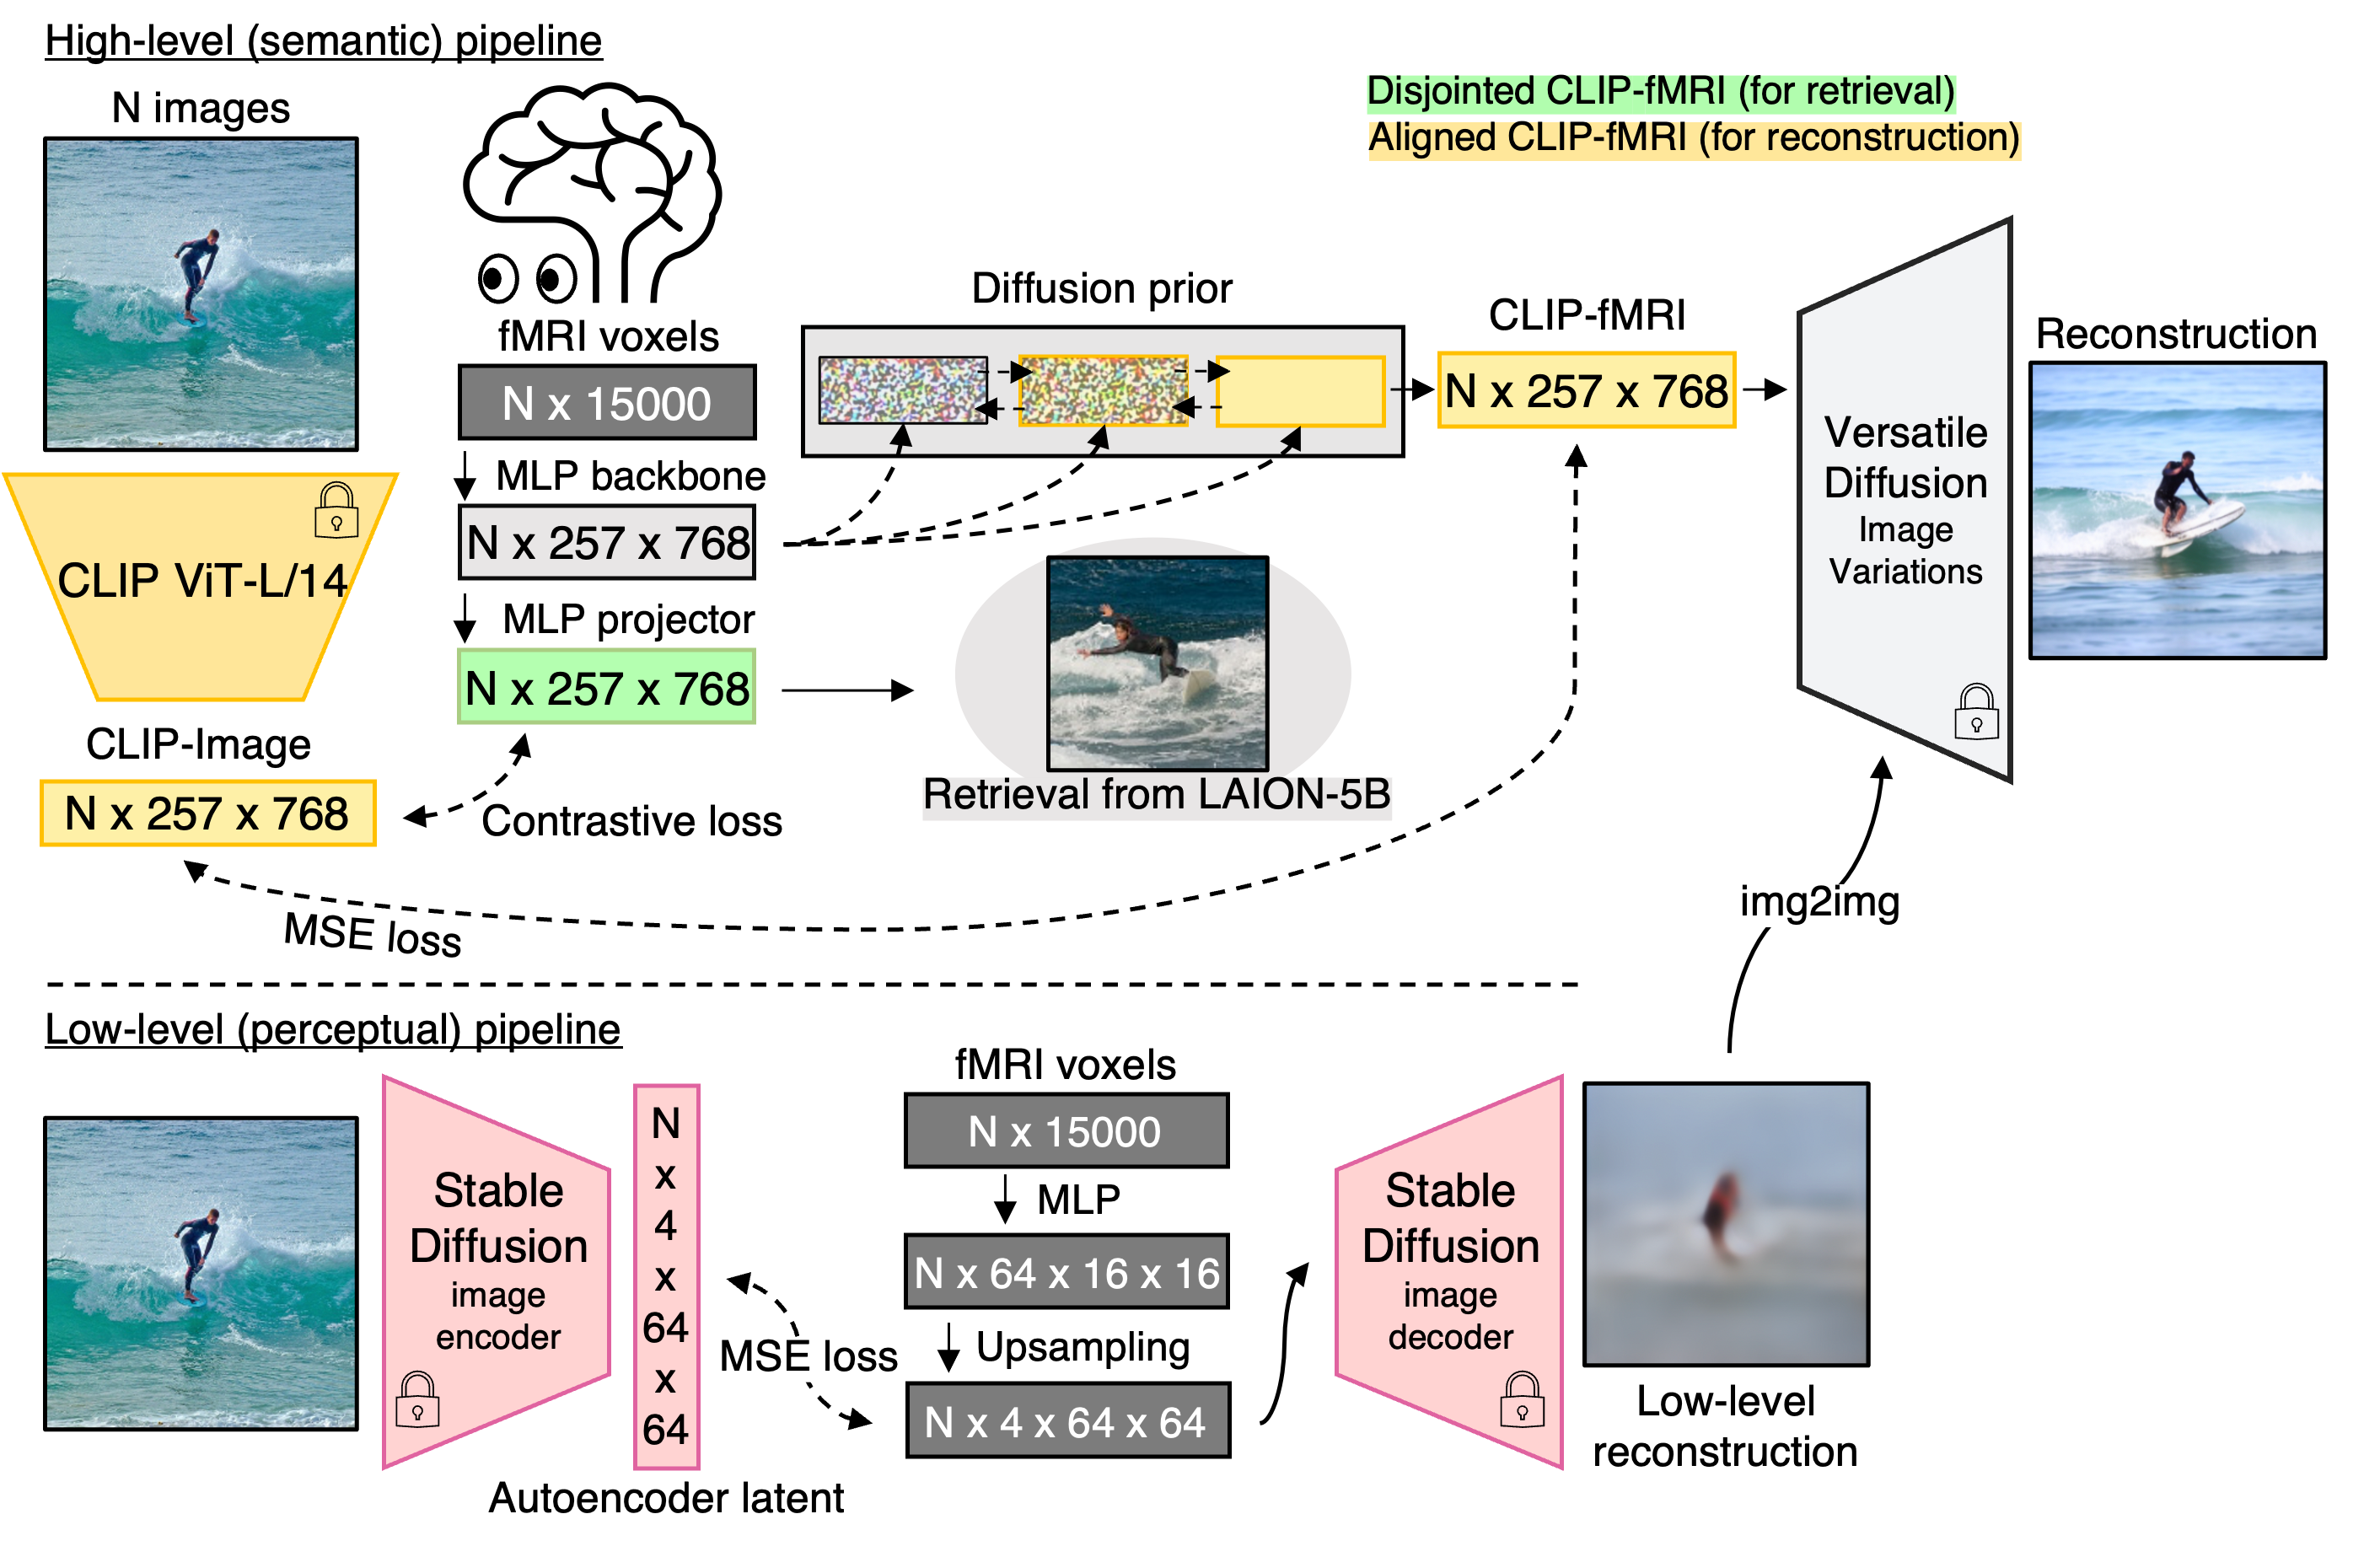

This tutorial demonstrates the application of a deep neural network modeling paradigm to the prediction of hemodynamic activity in the human visual system. Specifically, we'll use features from OpenAI's CLIP to predict voxelwise response patterns and representational geometries in a small sample of the massive 7T fMRI Natural Scenes DataSet.




Much of the code in this tutorial comes from [*DeepDive*](https://github.com/ColinConwell/DeepDive): a toolkit (and package, currently in construction) for comprehensive and highly efficient deep net feature extraction, in concert with tools for representational similarity analysis and linear probes.

Keep in mind this is an active work in progress. If you have any issues, please refer to the associated [Github](https://github.com/ColinConwell/DeepNSD) repo(s).

We welcome any and all constructive feedback.

In [2]:
# first things first, we'll clone the Github repo...
!git clone https://github.com/ColinConwell/DeepDive
!git clone https://github.com/ColinConwell/DeepNSD
!cp -r DeepDive/deepdive DeepNSD/model_opts #toolbox
%cd DeepNSD

Cloning into 'DeepDive'...
remote: Enumerating objects: 293, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 293 (delta 20), reused 37 (delta 17), pack-reused 242
Receiving objects: 100% (293/293), 2.52 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Cloning into 'DeepNSD'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 116 (delta 22), reused 17 (delta 5), pack-reused 67
Receiving objects: 100% (116/116), 766.10 KiB | 14.45 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/DeepNSD


The brain data we'll be predicting today is the fMRI activity of 1 human subject across 16 visual cortical regions, collected in response to 1000 natural scenes from the Microsoft Coco (2017) image set.

We load and manipulate this data as a python class, with native functions built-in that allow for visualizing stimulus examples, grouping the neural responses by various kinds of metadata, and quickly constructing RDMs across arbitrary levels of organization.

In [3]:
#functions for loading and manipulating the neural data
from neural_data import *

In [4]:
# here, we instantiate the neural_data class
benchmark = NaturalScenesDataset()

Downloading...
From: https://drive.google.com/uc?export=download&id=176Vygj8SMic_p9tZtgqw60GtSA50D_VG
To: /content/DeepNSD/neural_data/natural_scenes_demo.tar.bz2
100%|██████████| 395M/395M [00:09<00:00, 39.8MB/s]


The main data of the **benchmark()** class is organized into 3 main dataframes:
*   **benchmark.response_data** contains the average brain activity per voxel (row) per stimulus (column); the index is the *voxel_id*
*   **benchmark.metadata** contains metadata (columns) about each voxel (row), for example its ROI; the index is the *voxel_id*
*   **benchmark.stimulus_data** contains information (columns) about each stimulus (row), including its relative path



In [ ]:
# here, we see the shapes of these 3 main dataframes
# there are 8461 voxels in our dataset
# ...responding to 1000 images.
print(benchmark.response_data.shape,
      benchmark.metadata.shape,
      benchmark.stimulus_data.shape)

(8461, 1000) (8461, 6) (1000, 4)


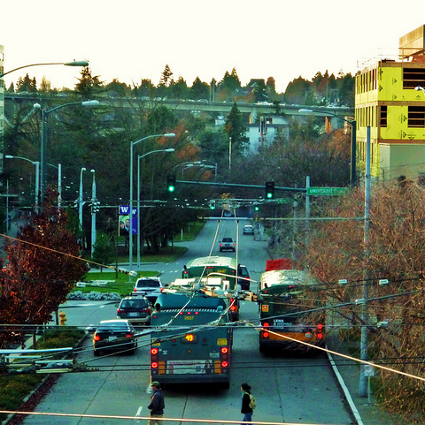

In [5]:
# here's a sample stimulus (stimulus 0)
benchmark.view_sample_stimulus(1)

Constructing target RDMs in this case requires simply specifying a set of grouping_variables (*group_vars*) -- whatever is available in the benchmark metadata. In this case, we'll create one RDM per ROI per subject.

In [ ]:
# here are the various grouping_variables we could use from the metadata
print(benchmark.metadata.columns.to_list())

['subj_id', 'roi_name', 'roi_voxel_idx', 'voxel_reliability', 'roi_group', 'roi_level']


In [ ]:
# while the neural_data loads with a default set of RDMs,
# here we'll overwrite these with our own
benchmark.rdms = benchmark.get_rdms(group_vars = ['roi_name', 'subj_id'])

# note, we also want to save the indices associated with the responses
# that constitute each RDM, so we can parse the predicted responses
# in our neural encoding procedure (for voxel-encoding RSA)
benchmark.rdm_indices = benchmark.get_rdm_indices(['roi_name','subj_id'])

Having instantiated our neural data, we'll now 'instrumentalize' a deep neural network model to predict this data. In this example, we'll use a CLIP model, but there are a wide number of other options available in this repo.

In [ ]:
# functions for loading models
sys.path.append('model_opts')
from model_options import *

In [ ]:
# here's a sample of the models we've preprocessed for easy use.
list(get_model_options(model_source = 'timm').keys())[::21]

['beit_base_patch16_224_random',
 'crossvit_base_240_imagenet',
 'ecaresnet101d_random',
 'gmlp_s16_224_imagenet',
 'levit_256_random',
 'mobilenetv3_rw_imagenet',
 'repvgg_b1g4_random',
 'semnasnet_100_imagenet',
 'tresnet_l_random',
 'vit_base_patch16_sam_224_imagenet']

In [ ]:
# to use the clip model, we need to install CLIP
!pip install -q git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 1.3 MB/s 


This pipeline requires a few things for the models we want to test. It requires some **metadata** (the name of the model, what it's been trained on, what class of model it is); a **call** for loading the model; and (perhaps most importantly of all) the appropriate **image transforms** that'll convert our stimulus images into the right format (and distribution) for our model.

So long as you have a PyTorch model, a torchvision *transforms.Compose()* function, and a *model_string*, *model_name*, and *train_type*, you can use any model at your disposal, simply modifying the pipeline below without the *get_model_options()* function.

In [ ]:
model_string = 'ViT-B/32_clip'
model_option = get_model_options()[model_string]
model_name = model_option['model_name']
train_type = model_option['train_type']

image_transforms = get_recommended_transforms(model_string)
model = eval(model_option['call'])
model = model.eval()
if torch.cuda.is_available():
  model = model.cuda()

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 218MiB/s]


With our neural data instantiated, and model instrumentalized, we now begin the process of feature extraction. To do this, we first select our target layers (though in reality, you'll usually want to test all layers). We then hook the features from these target layers as we pass batches of images through the model.  Then (for computational tractability), we reduce the dimensionality of these features (using in this case a technique called sparse random projectiion).

In [ ]:
# tools for feature extraction
sys.path.append('model_opts')
from feature_extraction import *

In [ ]:
stimulus_loader = DataLoader(StimulusSet(benchmark.stimulus_data.image_path, image_transforms), batch_size = 64)
# this function creates a dataloader using the stimulus_data dataframe of our neural benchmark,
# and the image_transforms we loaded when we instrumentalized our model.

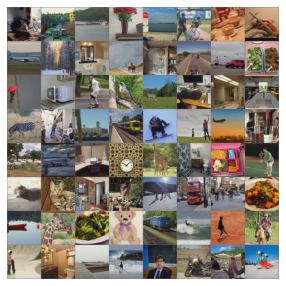

In [ ]:
# here's a sample of the dataloader (with the transforms reversed)
get_dataloader_sample(stimulus_loader, nrow = 8)

In [ ]:
# to get the names of the model layers we'll subselect from, we'll use a convenience function
# because we're testing a vision transformer, we'll then extract every other linear layer.
model_layers = get_empty_feature_maps(model, stimulus_loader, names_only = True)
target_layers = [layer for layer in model_layers if 'Linear' in layer
                 and int(layer.split('-')[1]) % 2 == 1]

In [ ]:
# once we've selected our target layers, we pass these, our model, and our dataloader through a convenience function:
feature_maps = get_all_feature_maps(model, stimulus_loader, layers_to_retain = target_layers)

Feature Extraction (Batch):   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# here are the dimensionalities of our extracted features
# obviously, these take up a lot of RAM!
for feature_map in feature_maps:
  print(feature_map, feature_maps[feature_map].shape)

Linear-1 (1000, 153600)
Linear-3 (1000, 153600)
Linear-5 (1000, 153600)
Linear-7 (1000, 153600)
Linear-9 (1000, 153600)
Linear-11 (1000, 153600)
Linear-13 (1000, 153600)
Linear-15 (1000, 153600)
Linear-17 (1000, 153600)
Linear-19 (1000, 153600)
Linear-21 (1000, 153600)
Linear-23 (1000, 153600)


In [ ]:
# tools for dimensionality reduction
sys.path.append('model_opts')
from feature_reduction import *

In [ ]:
# we'll now pass our extracted feature maps (along with a model_string to save temporary files)
# through another convenience function, with parameters for the sparse random projection.
# after reducing its dimensionality, we delete the full-sized feature_map with the keep_ argument
feature_maps_redux = srp_extraction(model_string, feature_maps = feature_maps, eps = 0.1, seed = 0,
                                    delete_original_feature_maps = True)

SRP Extraction (Layer):   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
# here are the dimensionalities of our reduced feature_maps
for feature_map in feature_maps_redux:
  print(feature_map, feature_maps_redux[feature_map].shape)

Linear-1 (1000, 5920)
Linear-3 (1000, 5920)
Linear-5 (1000, 5920)
Linear-7 (1000, 5920)
Linear-9 (1000, 5920)
Linear-11 (1000, 5920)
Linear-13 (1000, 5920)
Linear-15 (1000, 5920)
Linear-17 (1000, 5920)
Linear-19 (1000, 5920)
Linear-21 (1000, 5920)
Linear-23 (1000, 5920)


Having extracted our target features and reduced their dimensionality, we now move to the bulk of the analysis: the mapping of deep net features to the brain data. In this example, we consider two mapping metrics: classic representational similarity analysis and reweighted (voxel-wise encoding) representational similarity analysis.

The first of these methods involves calculating RDMs (built with the 1 - Pearson distance) directly from each feature space, then comparing these directly to the target RDMs with a second-order (1 - Pearson) distance metric.

The second of these methods involves first fitting an encoding model per voxel per feature space -- effectively regressing the features of a given model layer onto the activation profile of a target voxel. With these encoding models, we can generate predicted activity per voxel, and use this predicted activity to build predicted (voxel-reweighted) RDMs, which we subsequently compare with tthe second (1 - Pearson) distance metric to the relevant brain RDMs.

These two metric are comparable, but make different assumptions about the nature of the information that undergirds the similarity between brain and machine. Keep this in mind if comparing the two side by side!

In [ ]:
# tools for mapping deep nets to brains
# and also for some pretty plotting
sys.path.append('model_opts')
from mapping_methods import *

from plotnine import *
from plotnine import options
options.figure_size = (10,5)

In [ ]:
# here, we define some convenience functions for splitting our data into train and test sets
from sklearn.preprocessing import StandardScaler

def get_splithalf_xy(feature_map, response_data, scaling = StandardScaler()):
    data_splits = {'train': {}, 'test': {}}

    data_splits['train']['X'] = scaling.fit_transform(feature_map[::2,:])
    data_splits['test']['X'] = scaling.transform(feature_map[1::2,:])

    response_data = response_data.to_numpy()
    data_splits['train']['y'] = response_data[:,::2]
    data_splits['test']['y'] = response_data[:,1::2]

    return data_splits

def get_splithalf_rdms(rdms):
    split_rdms = {}
    for roi_name in rdms:
        split_rdms[roi_name] = {}
        for subj_id in rdms[roi_name]:
            split_rdms[roi_name][subj_id] = {'train': rdms[roi_name][subj_id][::2,::2],
                                            'test': rdms[roi_name][subj_id][1::2,1::2]}

    return split_rdms

In [ ]:
# here, we begin the scoring procedure, first defining which metrics we want to save
scoresheet_lists = {metric: [] for metric in ['crsa','wrsa']}

#we now loop through all our target_layers, scoring each as we go
for model_layer_index, model_layer in enumerate(tqdm(feature_maps_redux, desc = 'Mapping (Layer)')):
    xy = get_splithalf_xy(feature_maps_redux[model_layer], benchmark.response_data)

    # these are the value of the lambda penalty in the ridge regression
    alpha_values = np.logspace(-1,5,7).tolist()

    # this is the regression that maps the feature space to the voxels.
    # it's a multioutput regression, so it fits all voxels simultaneously.
    # it automatically performs leave one out cross-validation ...
    # ... to choose the optimal lambda penalty. we save this loocv score
    # ... as the predictive score for the training set, but also ...
    # ... evaluate the optimal lambda regression on a heldout test set.
    regression = RidgeCV(alphas=alpha_values, store_cv_values = True,
                          scoring = 'explained_variance')

    # here's where we extract the optimal lambda and generate the test predictions
    regression.fit(xy['train']['X'], xy['train']['y'].transpose())
    best_alpha_index = alpha_values.index(regression.alpha_)
    predictions = {'train': regression.cv_values_[:, :, best_alpha_index],
                   'test': xy['test']['X'].dot(regression.coef_.transpose()) + regression.intercept_}

    for metric in scoresheet_lists:

        if metric == 'crsa':
            # even though the classic rsa metric is nonparametric
            # it's still wise to split into a train / test set
            # for the purposes of selecting the maximally correspondent layers
            splithalf_rdms = get_splithalf_rdms(benchmark.rdms)
            model_rdms = {'train': 1 - np.corrcoef(feature_maps_redux[model_layer][::2,:]),
                          'test': 1 - np.corrcoef(feature_maps_redux[model_layer][1::2,:])}

            for score_set in ['train', 'test']:
                for roi_name in benchmark.rdms:
                    for subj_id in benchmark.rdms[roi_name]:
                        target_rdm = splithalf_rdms[roi_name][subj_id][score_set]
                        score = compare_rdms(model_rdms[score_set], target_rdm)
                        # what we've done in the lines above is loop through all
                        # possible [ROI][subj_id] RDMs and compared them to the layer RDM

                        # we save this score and other data in a dictionary
                        # for later aggregation in a scoresheet
                        scoresheet = {'score': score,
                                      'score_set': score_set,
                                      'roi_name': roi_name,
                                      'subj_id': subj_id,
                                      'model': model_name,
                                      'train_type': train_type,
                                      'model_layer': model_layer,
                                      'model_layer_index': model_layer_index,
                                      'distance_1': 'pearson_r',
                                      'distance_2': 'pearson_r'}

                        scoresheet_lists['crsa'].append(scoresheet)

        if metric == 'srpr':
            # we can, if we want, save the predictive scores per voxel
            # prior to aggregating the voxelwise predictions in an RDM
            for score_set in ['train','test']:
                if score_set == 'train':
                    y = xy['train']['y'].transpose()
                    y_pred = predictions['train']
                if score_set == 'test':
                    y = xy['test']['y'].transpose()
                    y_pred = predictions['test']
                score = score_func(y, y_pred)

                neuroid_ids = benchmark.response_data.index
                # notice in this dictionary that we're saving a score per voxel
                # individual units we occasionally called 'neuroids',
                # to have a general term across different brain units
                scoresheet = pd.DataFrame({'neuroid_id': neuroid_ids,
                                            'score': score,
                                            'alpha': alpha_values[best_alpha_index],
                                            'score_set': score_set,
                                            'score_type': 'pearson_r',
                                            'model': model_name,
                                            'train_type': train_type,
                                            'model_layer': model_layer,
                                            'model_layer_index': model_layer_index})


                scoresheet_lists['srpr'].append(scoresheet)

        if metric == 'wrsa':
            # now we perform the weighted rsa
            splifhalf_rdms = get_splithalf_rdms(benchmark.rdms)
            # the rdm_indices tell us which predictions
            # from the regression correspond to which voxel
            rdm_indices_dict = benchmark.rdm_indices

            for score_set in ['train', 'test']:
                for roi_name in benchmark.rdms:
                    for subj_id in benchmark.rdms[roi_name]:
                        # again we iterate through all [ROI][subj_id] combos ...
                        # aggregating the responses from the fitted regression
                        # into the relevant predicted RDMs we compare to actual RDMS
                        rdm_indices = rdm_indices_dict[roi_name][subj_id]
                        prediction_subset = predictions[score_set][:,rdm_indices]
                        model_rdm = 1 - np.corrcoef(prediction_subset)
                        target_rdm = splithalf_rdms[roi_name][subj_id][score_set]
                        score = compare_rdms(model_rdm, target_rdm)

                        # this scoresheet should be identical in its dimensionality
                        # and composition to the crsa scoresheet
                        scoresheet = {'score': score,
                                      'score_set': score_set,
                                      'alpha': alpha_values[best_alpha_index],
                                      'roi_name': roi_name,
                                      'subj_id': subj_id,
                                      'model': model_name,
                                      'train_type': train_type,
                                      'model_layer': model_layer,
                                      'model_layer_index': model_layer_index,
                                      'distance_1': 'pearson_r',
                                      'distance_2': 'pearson_r'}

                        scoresheet_lists['wrsa'].append(scoresheet)

# now, we concatenate our various results into easily accessible dataframes
# adding relevant bits of metadata for group_by operations
prime_metadata = benchmark.metadata[['roi_name','subj_id']]

results = {}

for metric in scoresheet_lists:
  if 'rsa' in metric:
      results[metric] = pd.DataFrame(scoresheet_lists[metric])
  if 'srpr' in metric:
      results[metric] = (pd.concat(scoresheet_lists[metric])
                          .merge(prime_metadata, on = benchmark.index_name))

Mapping (Layer):   0%|          | 0/12 [00:00<?, ?it/s]

After fitting our regressions and computing the relevant representational similarities, we can now visualize the scores for individual ROIs across model layer, simultaneously scrutinizing the drop in generalization from training to test set (if in fact there is one).

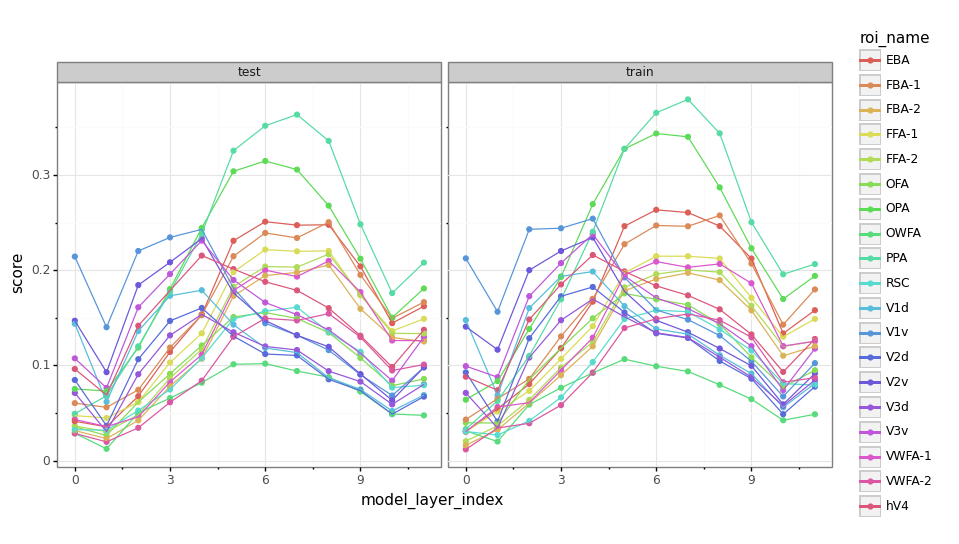

<ggplot: (8745850292221)>

In [ ]:
(ggplot(results['crsa'], aes('model_layer_index', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_point() + geom_line() + facet_wrap('~score_set') + theme_bw())

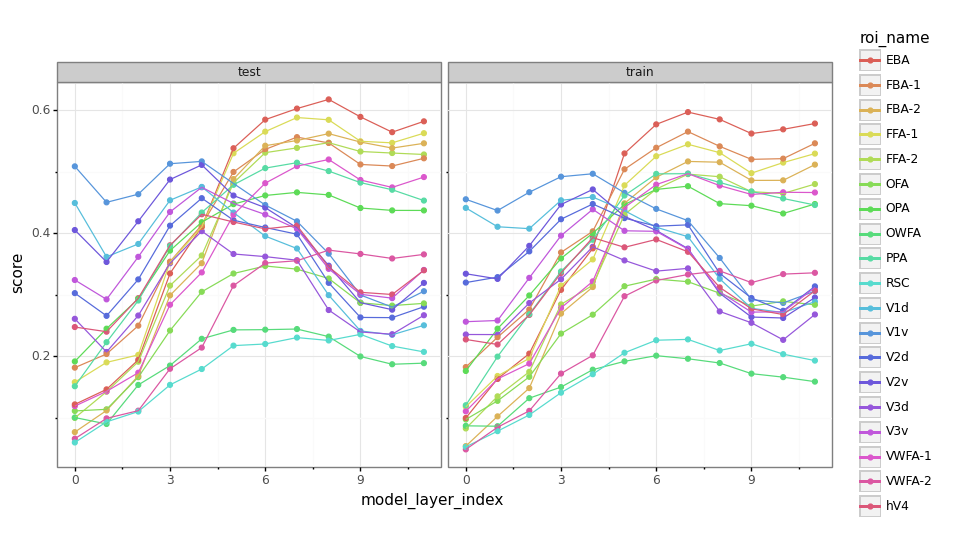

<ggplot: (8745849510213)>

In [ ]:
(ggplot(results['wrsa'], aes('model_layer_index', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_point() + geom_line() + facet_wrap('~score_set') + theme_bw())

And there we have it! You've just benchmarked a CLIP model on the NSD data. Obviously, there are many more combinations you could try and different aggregates of the mappings you could scrutinize, but we leave this to you. Happy mapping!